# **AgroScan - Crop Disease Classifier** #

In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.applications import InceptionV3

## **Dataset** ##

In [2]:
DATA_DIR = '.\\PlantVillage'

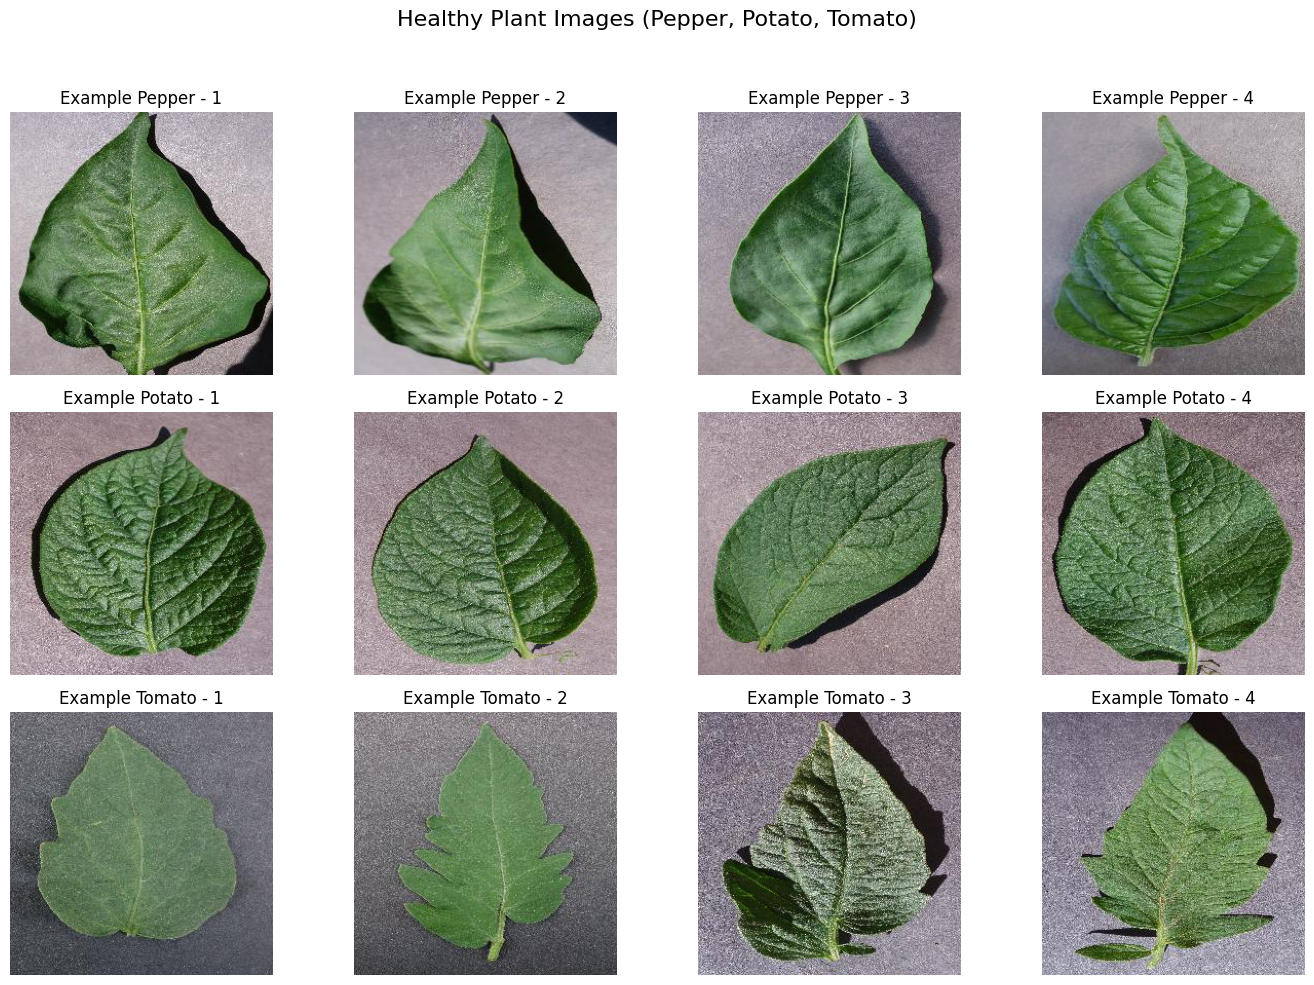

In [3]:
# Example Directories
healthy_pepper_dir = os.path.join(DATA_DIR, 'Pepper__bell___healthy')
healthy_potato_dir = os.path.join(DATA_DIR, 'Potato___healthy')
healthy_tomato_dir = os.path.join(DATA_DIR, 'Tomato_healthy')

pepper_filenames = [os.path.join(healthy_pepper_dir, filename) for filename in os.listdir(healthy_pepper_dir)]
potato_filenames = [os.path.join(healthy_potato_dir , filename) for filename in os.listdir(healthy_potato_dir)]
tomato_filenames = [os.path.join(healthy_tomato_dir, filename) for filename in os.listdir(healthy_tomato_dir)]

fig, axes = plt.subplots(3, 4, figsize=(14, 10))
fig.suptitle('Healthy Plant Images (Pepper, Potato, Tomato)', fontsize=16)

# Plot the first 4 images of each healthy crop
for i, pepper_image in enumerate(pepper_filenames[:4]):
    img = tf.keras.utils.load_img(pepper_image)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Example Pepper - {i+1}')
    axes[0, i].axis('off')

for i, potato_image in enumerate(potato_filenames[:4]):
    img = tf.keras.utils.load_img(potato_image)
    axes[1, i].imshow(img)
    axes[1, i].set_title(f'Example Potato - {i+1}')
    axes[1, i].axis('off')

for i, tomato_image in enumerate(tomato_filenames[:4]):
    img = tf.keras.utils.load_img(tomato_image)
    axes[2, i].imshow(img)
    axes[2, i].set_title(f'Example Tomato - {i+1}')
    axes[2, i].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [4]:
# Image Size
pepper_dir = os.path.join(DATA_DIR, 'Pepper__bell___healthy')
sample_image_pepper = tf.keras.preprocessing.image.load_img(os.path.join(pepper_dir, os.listdir(pepper_dir)[0]))
sample_array = tf.keras.preprocessing.image.img_to_array(sample_image_pepper)

print(f"Each image has shape: {sample_array.shape}")

Each image has shape: (256, 256, 3)


## **Training & Validation Dataset** ##

In [5]:
def train_val_test():
    # Add Rescaling Layer
    data_augmentation = tf.keras.Sequential([
        RandomFlip("horizontal"),
        RandomRotation(0.1),
        RandomZoom(0.1),
        Rescaling(1./255)  # Normalize images to [0, 1]
    ])

    training_dataset, validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        directory= './PlantVillage',
        label_mode= 'categorical',
        image_size= (128, 128),
        batch_size= 64,
        validation_split= 0.2,
        subset= 'both',
        shuffle= True,
        seed= 9
    )

    # Apply data augmentation and rescaling to training dataset
    training_dataset = training_dataset.map(
        lambda x, y: (data_augmentation(x), y),
        num_parallel_calls= tf.data.AUTOTUNE
    )

    # Apply rescaling to validation and test datasets
    val_batches = int(validation_dataset.cardinality())
    test_batches = val_batches // 5

    test_dataset = validation_dataset.take(test_batches).map(
        lambda x, y: (Rescaling(1./255)(x), y)
    )
    validation_dataset = validation_dataset.skip(test_batches).map(
        lambda x, y: (Rescaling(1./255)(x), y)
    )

    return training_dataset.prefetch(tf.data.AUTOTUNE), \
           validation_dataset.prefetch(tf.data.AUTOTUNE), \
           test_dataset.prefetch(tf.data.AUTOTUNE)

## **The Model** ##

In [6]:
def final_model(input_shape=(128, 128, 3), num_classes=15): 
    pre_trained_model = InceptionV3(
        weights= 'imagenet', 
        include_top= False,  
        input_shape= input_shape  
    )

    for layer in pre_trained_model.layers[:100]:  # Fine-tune top layers
        layer.trainable = False

    x = tf.keras.layers.Flatten()(pre_trained_model.output)
    x = tf.keras.layers.Dense(512, activation= 'relu', kernel_regularizer= tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(num_classes, activation= 'softmax')(x)

    model = tf.keras.Model(inputs=pre_trained_model.input, outputs=x)
    
    model.compile(
        optimizer= tf.keras.optimizers.Adam(learning_rate= 0.0001),
        loss= 'categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [7]:
class EarlyStoppingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('val_accuracy', 0) > 0.95:
            self.model.stop_training = True
            print("\nValidation accuracy exceeded threshold. Stopping training!")


In [8]:
# Training the model
training_dataset, validation_dataset, test_dataset = train_val_test()
model = final_model()

Found 20638 files belonging to 15 classes.
Using 16511 files for training.
Using 4127 files for validation.


## **Model Training** ##

In [9]:
history = model.fit(
    training_dataset,
    validation_data=validation_dataset,
    epochs= 30,
    callbacks=[EarlyStoppingCallback()],
    verbose= 1
)

Epoch 1/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 533s 2s/step - accuracy: 0.4572 - loss: 10.4571 - val_accuracy: 0.8522 - val_loss: 6.3307
Epoch 2/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 508s 2s/step - accuracy: 0.8728 - loss: 5.5151 - val_accuracy: 0.8971 - val_loss: 3.5571
Epoch 3/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 517s 2s/step - accuracy: 0.9332 - loss: 3.0204 - val_accuracy: 0.9354 - val_loss: 1.9482
Epoch 4/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 525s 2s/step - accuracy: 0.9494 - loss: 1.6632 - val_accuracy: 0.9284 - val_loss: 1.1583
Epoch 5/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 595s 2s/step - accuracy: 0.9588 - loss: 0.9272 - val_accuracy: 0.9354 - val_loss: 0.7103
Epoch 6/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 875s 3s/step - accuracy: 0.9668 - loss: 0.5401 - val_accuracy: 0.9393 - val_loss: 0.4780
Epoch 7/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 464s 2s/step - accuracy: 0.9744 - loss: 0.3259 - val_accuracy: 0.9445 - val_loss: 0.3589
Epoch 8/30
258/258 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9774 - loss: 0.2171
Validation 

## **Model Plot** ##

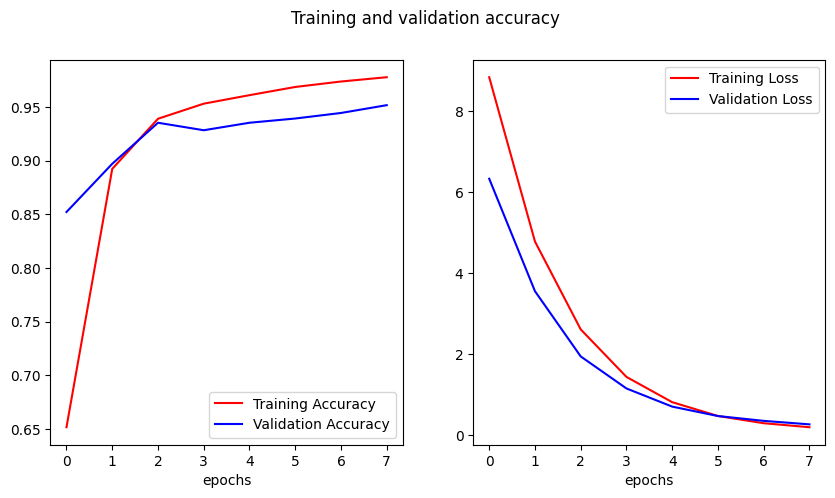

In [10]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

In [14]:
# Save model into .h5
model.save("agroscan_model.h5")

In [15]:
# Convert to TensorFlow.js format
import tensorflowjs as tfjs
!tensorflowjs_converter --input_format= keras agroscan_model.h5 tfjs_model

ModuleNotFoundError: No module named 'tensorflowjs'

In [16]:
# Save the model architecture to a JSON file
model_json = model.to_json()

# Write the model architecture to a file
with open("model_architecture.json", "w") as json_file:
    json_file.write(model_json)
